# Thematic differences (Hungary)

DHH23 Parliament group

Author: Pontus H.

In [212]:
# Set the theme here
THEME = 'gender_HU'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'

In [213]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd

In [214]:
# Hungarian stopwords
with open('../data/stopwords-hu.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [215]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 10 # This was lowered from 50 to 10 for gender_HU
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  #nr_topics="25",
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [216]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,u2017-02-20-71,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-02-20,Unicameralism,7,NaN,73,1,NaN,Reference,...,LMP-frakció,A Lehet Más a Politika parlamenti frakciója,Opposition,"Szél, Bernadett",F,1977.0,"Hát, a Fidesz új stílusa azért nem semmi! Már ...","[[Zaj, felzúdulás, közbeszólások a kormánypár...",-0.834961,1393
1,u2017-10-09-1,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-10-09,Unicameralism,7,NaN,85,4,NaN,Reference,...,KNDP-frakció,A Kereszténydemokrata Néppárt parlamenti frakc...,Coalition,"Aradszki, András",M,1956.0,Tisztelt Elnök Úr! Tisztelt Ház! Európa ismét ...,Az ember központi szerepének kijelentése a cs...,0.463135,4429
2,u2017-09-20-5,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-09-20,Unicameralism,7,NaN,84,3,NaN,Reference,...,MSZP-frakció,A Magyar Szocialista Párt parlamenti frakciója,Opposition,"Legény, Zsolt",M,1978.0,"Köszönöm a szót és a lehetőséget, elnök úr. Ti...",Tisztelt Ház! Tisztelt Államtitkár Úr! Tiszte...,0.297607,7062
3,u2017-03-08-13,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-03-08,Unicameralism,7,NaN,74,3,NaN,Reference,...,LMP-frakció,A Lehet Más a Politika parlamenti frakciója,Opposition,"Szél, Bernadett",F,1977.0,"Köszönöm a szót, elnök úr. Tisztelt Országgyűl...","Tisztelt Országgyűlés! Március 8-a, nőnap van...",0.068970,21134
4,u2017-04-04-75,"Hungarian parliamentary corpus ParlaMint-HU, l...",2017-04-04,Unicameralism,7,NaN,76,2,NaN,Reference,...,KNDP-frakció,A Kereszténydemokrata Néppárt parlamenti frakc...,Coalition,"Hollik, István",M,1982.0,"Az a helyzet, hogy az önök megnyilatkozásaiból...",hu vagy a 444.hu csinált: rémhíreket terjeszte...,-0.231079,4323


In [217]:
df['Speaker_party'].describe()

count              109
unique              12
top       KNDP-frakció
freq                28
Name: Speaker_party, dtype: object

In [218]:
# Reference running time for this cell: 4min 00s
topics, probs = topic_model.fit_transform(df['speech'])


In [219]:
# Reduce outliers
# threshold was decreased from 0.1 to 0.05 for gender_HU
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=0.05)


In [220]:
pd.Series(new_topics).value_counts()

0    46
1    34
2    22
3    11
dtype: int64

In [221]:
#topic_model.save(f"../data/topic_model_epsilon{HDBSCAN_CLUSTER_SELECTION_EPSILON}_clustersize{HDBSCAN_MIN_CLUSTER_SIZE}.bin")

In [222]:
#topic_model = BERTopic.load("../data/topic_model_epsilon0_clustersize50.bin")

In [223]:
# Number of topics
print(f"Number of topics before: {len(pd.Series(topics).unique())}")
print(f"Number of topics before: {len(pd.Series(new_topics).unique())}")

Number of topics before: 5
Number of topics before: 4


In [224]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

 1    40
 0    29
 2    17
-1    16
 3    11
dtype: int64

In [225]:
topic_model.visualize_topics()

Topics over time

In [226]:
# Reference running time for this cell: 2min 30s

# topics_over_time = topic_model.topics_over_time(df['speech'], df['Date'].to_list(), nr_bins=20)

In [227]:
# Save the topics_over_time dataframe to a feather file
#topics_over_time.to_feather("../data/topics_over_time.feather")

In [228]:
# topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)
#topic_model.visualize_topics_over_time(topics_over_time, topics=[0,18])


What is interesting about the plot above is that the keywords associated with the topic CHANGE over time! Maybe this could be a useful pointer towards further exploration.

In [229]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

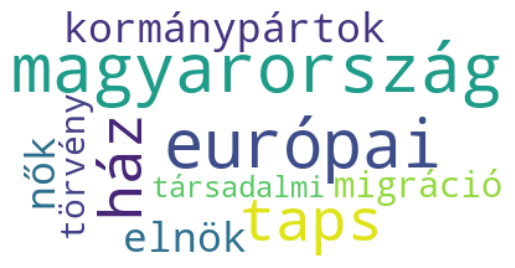

In [230]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

In [231]:
# topic_model.visualize_heatmap(n_clusters=5, top_n_topics=10)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [232]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
get_keywords(0)

['magyarország',
 'európai',
 'taps',
 'ház',
 'kormánypártok',
 'elnök',
 'nők',
 'migráció',
 'törvény',
 'társadalmi']

In [233]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
speech_topic_party.loc[speech_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
speech_topic_party.loc[speech_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,29,14,2
1,10,20,3
2,4,15,2
3,5,4,1


In [234]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,60.4,26.4,25.0
1,20.8,37.7,37.5
2,8.3,28.3,25.0
3,10.4,7.5,12.5


In [235]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,Fidesz-KDNP,OTHER,Opposition,keywords
topic,,,,
0,60.4,26.4,25.0,"[magyarország, európai, taps, ház, kormánypárt..."
1,20.8,37.7,37.5,"[magyar, erőszak, fidesz, józsef, kínai, polit..."
2,8.3,28.3,25.0,"[fog, magyar, 40, nyugdíjba, tudják, alaptörvé..."
3,10.4,7.5,12.5,"[német, homoszexuális, pedofília, kijelentések..."


In [236]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,Fidesz-KDNP,OTHER,Opposition
0,0,64.4,31.1,4.4
1,1,30.3,60.6,9.1
2,2,19.0,71.4,9.5
3,3,50.0,40.0,10.0


Calculate mean sentiment for each topic per party

In [237]:
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'Fidesz-KDNP' if the name contains Fidesz-frakció,  KNDP-frakció or Fidesz
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('Fidesz-frakció|KNDP-frakció|Fidesz'), 'party'] = 'Fidesz-KDNP'
# Set the party name to 'Opposition' if the name contains MSZP or MSZP-frakció
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('MSZP|MSZP-frakció'), 'party'] = 'Opposition'
# Set the party name to 'OTHER' if the party name does not contain 'Fidesz-KDNP' or 'Opposition'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('Fidesz-KDNP|Opposition'), 'party'] = 'OTHER'
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,Fidesz-KDNP,OTHER,Opposition
topic,,,
0,-0.10,-0.35,-0.09
1,-0.67,-0.76,-0.60
2,-0.32,-0.58,-0.71
3,-0.65,-0.79,0.13


In [238]:
topic_model.get_representative_docs(9)

In [239]:
df['Speaker_party'].value_counts()
# Group 1: Fidesz-frakció + KNDP-frakció + Fidesz = Fidesz-KDNP
# Group 2: MSZP + MSZP-frakció = Opposition
# Group 3: Rest = Other


KNDP-frakció         28
Fidesz-frakció       20
LMP-frakció          13
JOBBIK-frakció       12
Párbeszéd-frakció    12
MSZP-frakció          7
DK-frakció            7
Mi Hazánk             5
Volner                2
MSZP                  1
LMP                   1
MNOÖ                  1
Name: Speaker_party, dtype: int64